In [7]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.kernels.transformations.invariant import FiniteGroup, SumGroupInvariantKernel, ProductGroupInvariantKernel

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(12345)

In [11]:
# prepare some plotting utilities
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50))
xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1)]).T # [2500, 2]
xplot1d = jnp.stack([jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50)]).T # [50, 2]
def contour_plot(Z, ax):
    ax.contourf(x1_plot, x2_plot, Z.reshape(50, 50))
    ax.scatter(X[:,0], X[:,1],c="red", marker="x", label="data")
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)


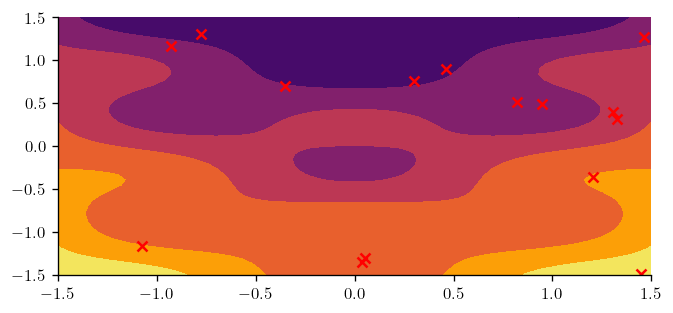

In [12]:


# ground truth function
def f(x): 
    return (x[:,0:1]**2  - 2*x[:,1:2] + jnp.cos(3*x[:,0:1])*jnp.sin(5*x[:,1:2]))

# simulate a dataset of 15 observations
n = 15
X = jr.uniform(key, shape=(n,2), minval=-1.5, maxval=1.5)
y = f(X)
D = gpx.Dataset(X=X, y=y)

# plot the ground truth function
fig, ax = plt.subplots()
contour_plot(f(xplot2d), ax)



In [51]:
def build_prior_and_plot_samples(kernel: gpx.kernels.AbstractKernel):
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    samples = prior.predict(xplot2d).sample(seed=jr.PRNGKey(12345), sample_shape=(5,))
    _, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    for i in range(5):
        contour_plot(samples[i,:], ax[i])
    return prior



def fit_and_plot_samples(kernel: gpx.kernels.AbstractKernel):
    meanf = gpx.mean_functions.Zero()
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=1e-3)
    obj = gpx.objectives.ConjugateMLL(negative=True)
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = prior * likelihood
    opt_posterior, _ = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=True)
    samples = opt_posterior.predict(xplot2d, D).sample(seed=jr.PRNGKey(12345), sample_shape=(5,))
    _, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
    for i in range(5):
        contour_plot(samples[i,:], ax[i])
    return opt_posterior

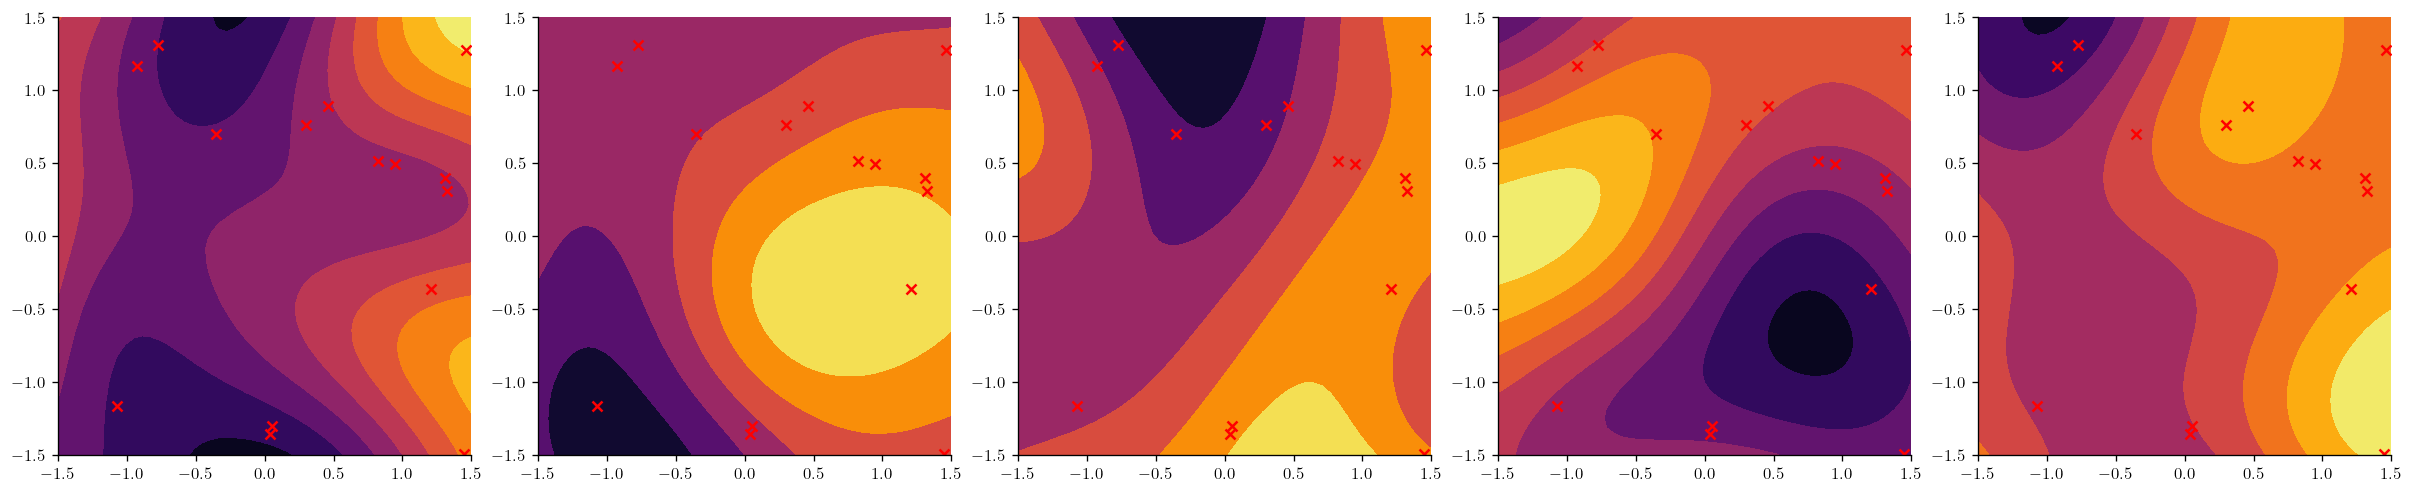

In [29]:
kernel = gpx.kernels.RBF(lengthscale=jnp.array([1.0, 1.0]), variance = jnp.var(D.y))
prior = build_prior_and_plot_samples(kernel)

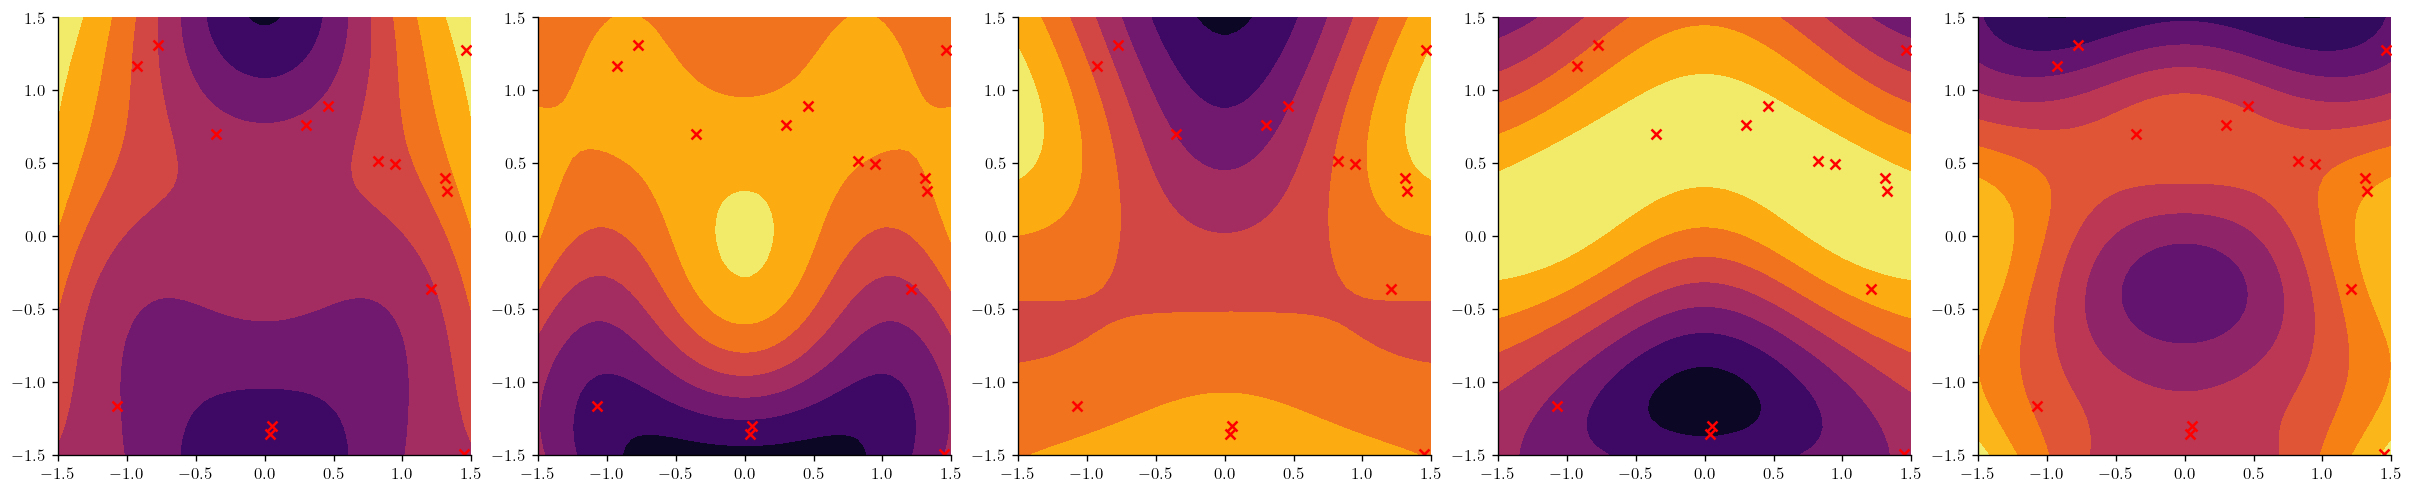

In [30]:
group_action = lambda x: jnp.stack([x, x * jnp.array([-1,1])], axis=0)
kernel = SumGroupInvariantKernel(base_kernel = kernel, group = FiniteGroup(group_action))
prior = build_prior_and_plot_samples(kernel)

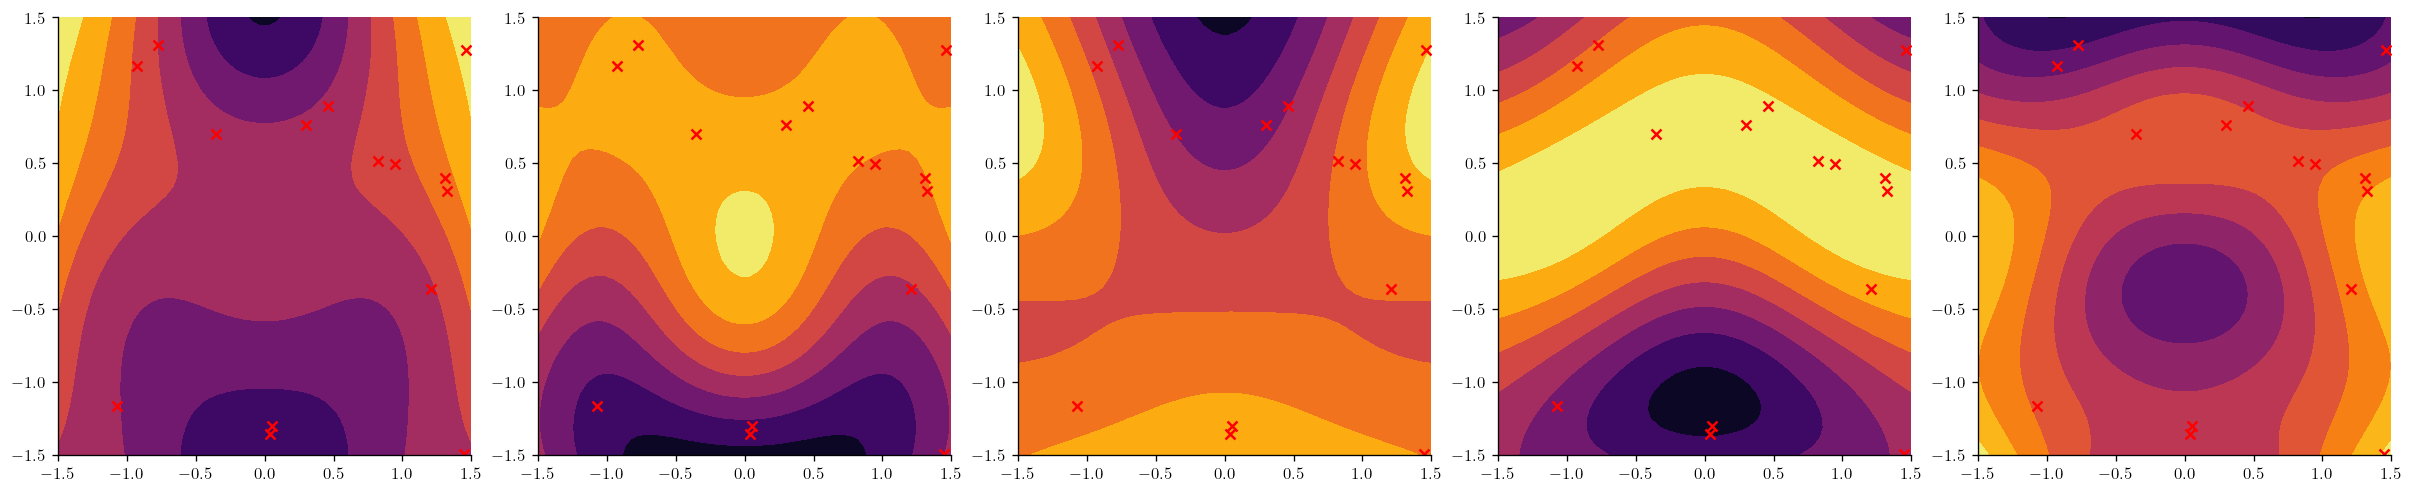

In [44]:
group_action = lambda x: jnp.stack([jnp.abs(x[0]),x[1]], axis=0).reshape(1,-1)
kernel = SumGroupInvariantKernel(base_kernel = kernel, group = FiniteGroup(group_action))
prior = build_prior_and_plot_samples(kernel)

Optimization terminated successfully.
         Current function value: 19.328203
         Iterations: 39
         Function evaluations: 42
         Gradient evaluations: 42


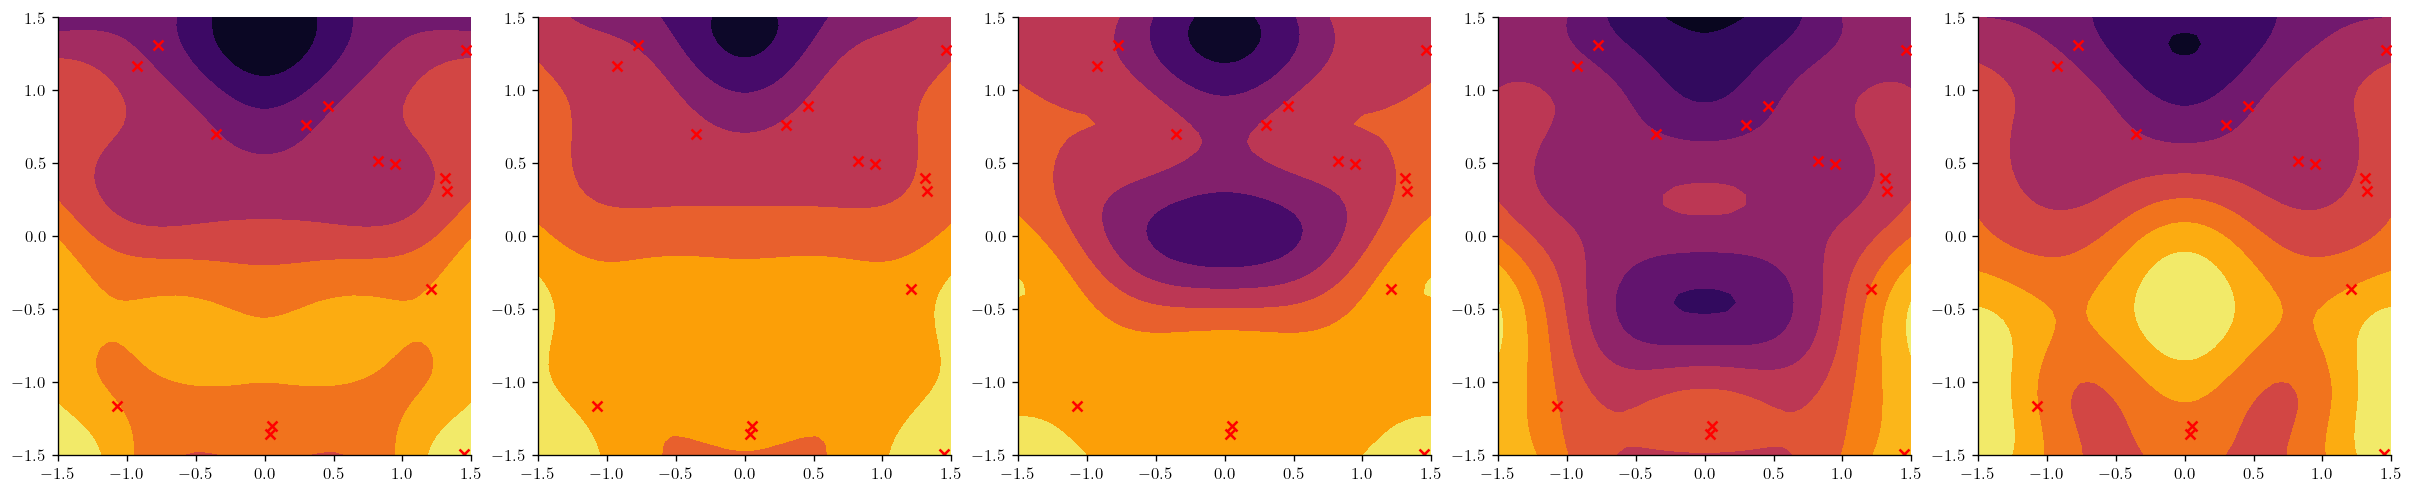

In [52]:
opt_posterior = fit_and_plot_samples(kernel)